## 1. Introduction

The Emergency and Security Coordinating Centre (CECOES 1-1-2) performs the coordination of different resources available in the Canary Islands relating to emergencies, among others, the Canary Islands Emergency Service (SUC), Emergency and Rescue Group (GES), the different police forces (Local Police, National Police and Civil Guard), the Fire Service and the Domestic Violence Service. The next chart shows the different coordinated services.

<img src="cecoes.png" alt="CECOES 1-1-2" style="width:604px;height:328px;">

The prediction of incidents represents an important issue for emergency services organisations in order to accurately forecast the daily number of alerts by municipality, explain seasonal patterns in the frequency of incidents or even detect unusual events in historical records.

## 2. Forecasting the Number of Incidents using Time Series Models

TBATS is an acronym for the key features of the time series model proposed by [De Livera, 2010](#de_livera1)), that is, an exponential smoothing method with Trigonometric seasonal + Box-Cox transformation + ARMA model for residuals + Trend and Seasonal components


\begin{aligned}\label{eq:tbats1}
&y_t^{(\lambda)} = l_{t-1} + \varphi b_{t-1} + \sum_{i=1}^T s_{t-m_i}^{(i)} + \eta_t \\ 
&l_t = l_{t-1} + \varphi b_{t-1} + \alpha \eta_t \\ 
&b_t = (1-\varphi)b + \varphi b_{t-1} + \beta \eta_t \\ 
&s_{t}^{(i)} = s_{t-m_i}^{(i)} + \gamma_i \eta_t\\
&\phi(B)\nabla^d \eta_t=\theta(B) z_t
\end{aligned}

where $y_t^{\left(\lambda\right)}$ represents the Box-Cox transformed observation with  parameter $\lambda$ at time $t$, that is 

\begin{aligned}\label{eq:boxcox}
&y_t^{(\lambda)} = \left\{
\begin{array}{ll}
      \frac{y_t^\lambda-1}{\lambda}, & \lambda \neq 0, \\
      \log{y_t}, & \lambda = 0, 
\end{array} 
\right.
\end{aligned}

and $m_1,...,m_T$ denote the seasonal periods, $l_t$ is the local level in period $t$, $b$ and $b_t$ are the long and short-run trends in period $t$, respectively, and $\varphi$ is the parameter of the damped trend. Denoting $T$ as the total number of time values, the $i$th seasonal components at time $t$ in the model, for $i=1,...,T$, are given by $s_t^{(i)}=\sum_{j=1}^{K_i}s_{j,t}^{(i)}$, where

\begin{aligned}\label{eq:tbats2}
&s_{j,t}^{(i)} = s_{j,t-1}^{(i)}\cos\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\sin\left(\frac{2\pi j}{m_i}\right)+ \delta_1^{(i)} \eta_t  \\
&s_{j,t}^{*(i)} = -s_{j,t-1}\sin\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\cos\left(\frac{2\pi j}{m_i}\right)+ \delta_2^{(i)} \eta_t  \\
\end{aligned}

with $K_i$ the number of harmonics in the $i$th seasonal component. As in the previous model, $\eta_t$ and $z_t$ are a non-seasonal ARMA($p$,$q$) process and a Gaussian white noise process with zero mean and constant variance $\sigma^2$, respectively. The smoothing parameters are given by $\alpha, \beta, \gamma, \delta_1^{\left(i\right)}$ and $\delta_2^{\left(i\right)}$. 

### 2.1 Illustrative example

We are going to fit the daily number of incidents from January, 2013 to January, 2015, in the municipality of La Orotava (in Tenerife)

In [17]:
#install.packages("dplyr","forecast","ggplot2","zoo","scales")
require(dplyr)
require(forecast)
require(ggplot2)
require(zoo)
require(scales)

Loading required package: scales


In [39]:
load("serie1_orotava.RData")

In [7]:
serie1<-left_join(serie1,day_df[,c("date","fest")],by="date") 
serie5<-subset(serie1, date >= strftime('2010-01-01', format = '%Y-%m-%d') & date <= strftime('2015-01-31', format = '%Y-%m-%d'))
serie5 <- ts(serie5$N, frequency=365.25, start=c(2010,1,1))
serie5_days<-day_df[day_df$date>="2010-01-01" & day_df$date<="2015-01-31",]
serie5_days$time<-round(time(serie5),3)

serie5_hist<-window(serie5, 
                    start=min(serie5_days$time[serie5_days$date>="2010-01-01"]),
                    end=max(serie5_days$time[serie5_days$date<="2014-12-31"]) )

In [10]:
serie5tbats <- tbats(serie5_hist,seasonal.periods = c(7,30.4,365.25), use.parallel=TRUE, num.cores = 2)

In [25]:
fc <- forecast(serie5tbats, h=30)
pd<-funggcast(serie5,fc,serie5_days) 
pd<-pd[pd$date>="2014-10-28",]

Warning message:
"Removed 30 rows containing missing values (geom_path)."Warning message:
"Removed 65 rows containing missing values (geom_path)."

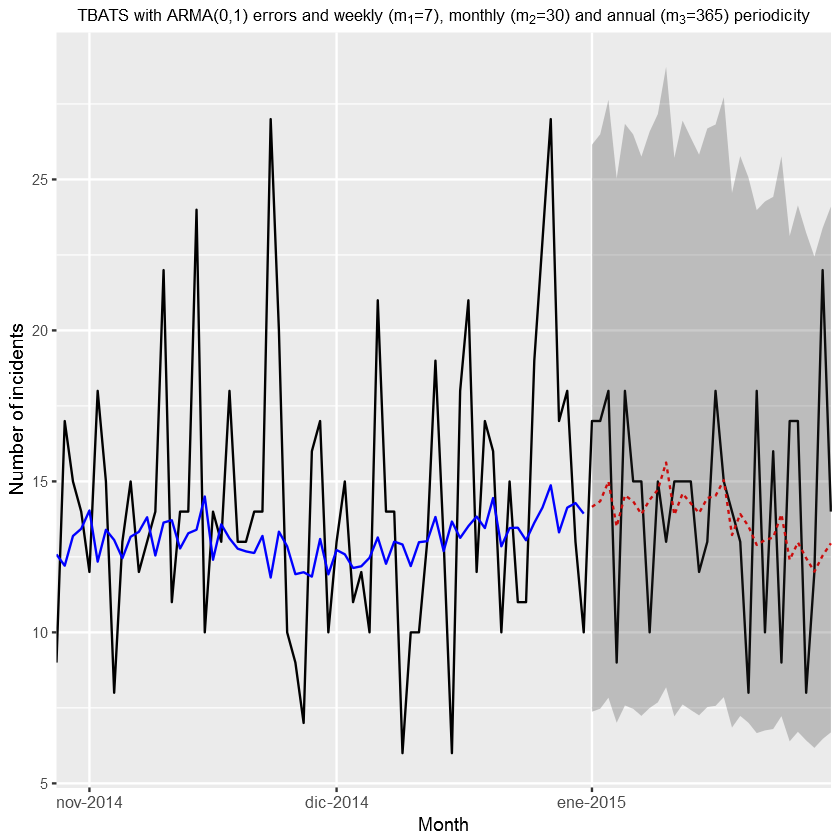

In [26]:
tbats_chart<-ggplot(data=pd,aes(x=date,y=observed)) +
     geom_line(col='black') +
     geom_line(aes(y=fitted),col='blue') +
     geom_line(aes(y=forecast),col='red',lty=2)+
     geom_ribbon(aes(ymin=lo95,ymax=hi95),alpha=.25)+
     scale_x_date(name='Month',date_breaks='1 month',date_minor_breaks='1 month',labels=date_format("%b-%Y"),expand=c(0,0))+
     scale_y_continuous(name='Number of incidents')+
     theme(axis.text.x=element_text(size=10),plot.title=element_text(hjust = 0.5),plot.subtitle=element_text(hjust = 0.5)) + 
     labs(subtitle=bquote('TBATS with ARMA('*.(serie5tbats$p)*','*.(serie5tbats$q)*') errors and weekly ('*m[1]*'=7), monthly ('*m[2]*'=30) and annual ('*m[3]*'=365) periodicity' ))

tbats_chart

## 3. Predicting the Medical Incidents using Classification Models

We demonstrate how to perform a classification of incidents by using the "mlr" package, see [Bischl, 2016](#bischl). The main goal of "mlr" is to provide a unified interface for machine learning tasks as classification, regression, cluster analysis and survival analysis in R. In this package are implemented the methods to carry out standard methods like cross-validation and hyperparameter tuning for different learners. A tutorial of "mlr" can be found in https://mlr-org.github.io/mlr/articles/mlr.html.


In [49]:
#install.packages("mlr","parallel","rpart","rpart.utils","rpart.plot","xgboost","ranger")
library("mlr")
library("parallel")
library("rpart")
library("rpart.utils")
library("rpart.plot")
library("dplyr")
library("xgboost")
library("ranger")

Warning message:
"package 'ranger' was built under R version 3.5.1"

### 3.1 Illustrative example

We are going to train classification models for predicting the medical incidents in "El Hierro" island. We have the following variables:

* MUNICIPALITY: the name of the municipality (88 values).
* MONTH: the month number, i.e. 1 (January) to 12 (December).
* DAY: the day within the month.
* HOUR: the hour of the day, i.e. 00:00 to 23:00.
* WEEK: a derived feature that holds the number of week in the month for any given day. For instance, days 1 to 7 fall in the first week, days 8-14 in the second, and so on.
* TIME: a derived feature that groups the variable HOUR into four daily quarters (00:00-753 05:59, 06:00-11:59, 12:00-17:59, 8:00-23:59).
* MEDICAL: a derived variable with true value ("M") if it is a medical emergency, and false value ("Not M") otherwise.
* N MEDICAL: a derived variable that counts the number of incidents with identical values in the previous variables.

The MEDICAL is the target variable for the prediction in the classification model.

In [41]:
load("data1_el_hierro.RData")

In [29]:
year_min = 2005
year_max = 2014

training = subset(data.tree, YEAR >= year_min & YEAR < year_max)  %>%
  group_by(MONTH, DAY, HOUR, TIME, WEEK, MUNICIPALITY, ISLAND, SANITARY) %>%
  summarise(N_MEDICAL = n()) %>%
  as.data.frame()
testing = subset(data.tree, YEAR >= year_max) %>%
  group_by(MONTH, DAY, HOUR, TIME, WEEK, MUNICIPALITY, ISLAND, SANITARY) %>%
  summarise(N_MEDICAL = n()) %>%
  as.data.frame()

training = droplevels(training)
testing = droplevels(testing)
training$ISLAND = NULL
testing$ISLAND = NULL

#checking training
table.training = table(training$SANITARY)
# getting proportion of classes
cat("Prop. classes in training set:")
prop.table(table.training)

# checking testing
table.testing = table(testing$SANITARY)
# getting proportion of classes
cat("Prop. classes in testing set:")
prop.table(table.testing)


Prop. classes in training set:


        M     Not_M 
0.4516644 0.5483356 

Prop. classes in testing set:


        M     Not_M 
0.4418605 0.5581395 

In [30]:
# define tasks
SANITARY.y = "SANITARY"
MED = "M"
NOT_MED = "Not_M"

mlr.task.training = makeClassifTask(
  data = training,
  target = "SANITARY", 
  positive = MED
)

mlr.task.testing = makeClassifTask(
  data = testing, 
  target = "SANITARY",
  positive = MED
)

mlr.training.ohe = createDummyFeatures(
  training,
  target = SANITARY.y
)

mlr.testing.ohe = createDummyFeatures(
  testing,
  target = SANITARY.y
)

mlr.task.training.ohe = makeClassifTask(
  data = mlr.training.ohe,
  target = "SANITARY", 
  positive = MED
)

mlr.task.testing.ohe = makeClassifTask(
  data = mlr.testing.ohe, 
  target = "SANITARY",
  positive = MED
)

mlr.resamp = makeResampleDesc(
  method = "CV", 
  iters = 5L
)

mlr.control = makeTuneControlGrid()

#### 3.1.1 Classication Tree (learner "rpart")

In [31]:
#define learner
mlr.learner.rpart = makeLearner(
  "classif.rpart", 
  predict.type = "prob",
  cp = 0.00445
)


In [32]:
#model fitting and predicting
training.model = mlr::train(mlr.learner.rpart, mlr.task.training)
mlr.predict = predict(training.model, mlr.task.testing)


Warning message:
"Cannot retrieve the data used to build the model (so cannot determine roundint and is.logical for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE."

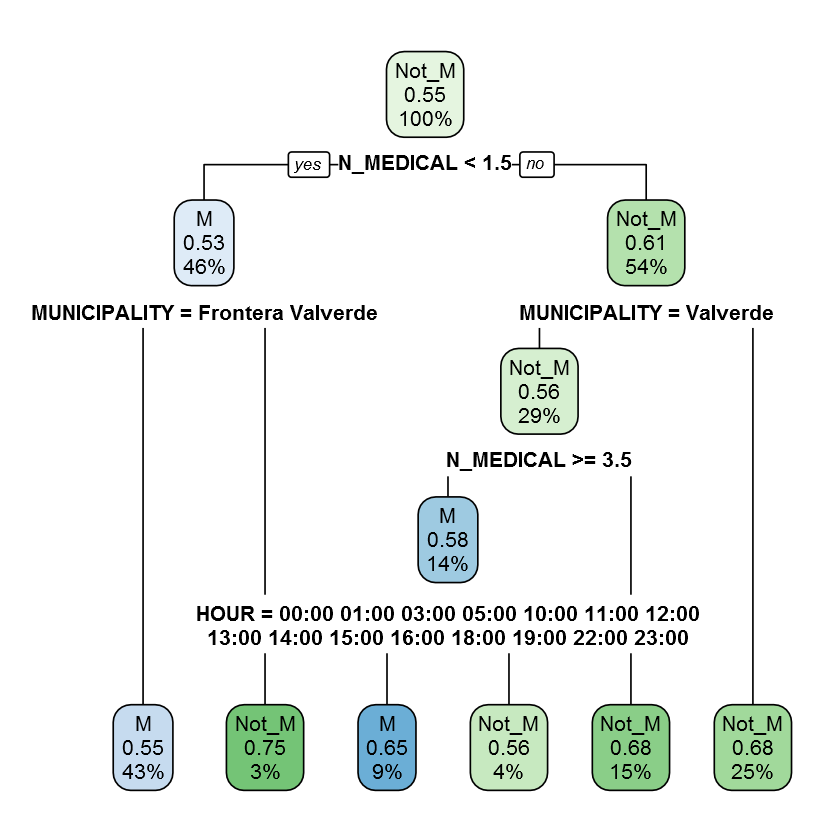

In [34]:
#decision tree
split.fun <- function(x, labs, digits, varlen, faclen) {
  # replace commas with spaces (needed for strwrap)
  labs <- gsub(",", " ", labs)
  for(i in 1:length(labs)) {
    # split labs[i] into multiple lines
    labs[i] <- paste(strwrap(labs[i], width = 50), collapse = "\n")
  }
  labs
}

rpart.plot(getLearnerModel(training.model),
           type = 2,
           extra = 108,
           fallen.leaves = T, 
           split.fun = split.fun
           )

        predicted
true       M Not_M -err.-
  M      997   447    447
  Not_M  593  1231    593
  -err.- 593   447   1040
       predicted
true    M         Not_M                        
  M     997       447       tpr: 0.69 fnr: 0.31
  Not_M 593       1231      fpr: 0.33 tnr: 0.67
        ppv: 0.63 for: 0.27 lrp: 2.12 acc: 0.68
        fdr: 0.37 npv: 0.73 lrm: 0.46 dor: 4.63


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr        f1       auc 
0.6817625 0.6904432 0.6748904 0.6572182 0.6744585 


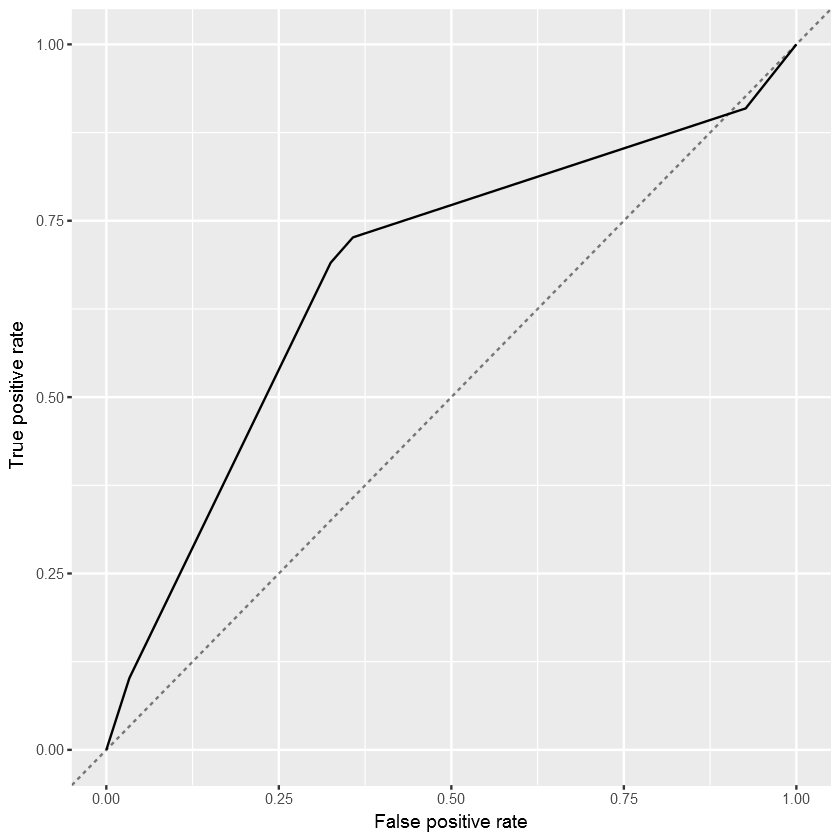

In [43]:
perf_ROC(mlr.predict)

#### 3.1.2 Extreme Gradient Boosting (learner "xgboost")

In [45]:
mlr.learner.xgb = makeLearner(
  "classif.xgboost",
  predict.type = "prob",
  objective = "binary:logistic",
  print_every_n = 100,
  verbose = 1,
  early_stopping_rounds = 10,
  eval_metric = "auc",
  nrounds = 300,
  subsample = 1, #0.8,
  colsample_bytree = 1, #0.8,
  eta = 0.01,
  gamma = 0.5, #1, # default 0
  max_depth = 6,
  nthread = detectCores() - 1
)

[1]	train-auc:0.675031 
Will train until train_auc hasn't improved in 10 rounds.

[101]	train-auc:0.692826 
[201]	train-auc:0.700526 
[300]	train-auc:0.707557 
        predicted
true       M Not_M -err.-
  M      997   447    447
  Not_M  593  1231    593
  -err.- 593   447   1040
       predicted
true    M         Not_M                        
  M     997       447       tpr: 0.69 fnr: 0.31
  Not_M 593       1231      fpr: 0.33 tnr: 0.67
        ppv: 0.63 for: 0.27 lrp: 2.12 acc: 0.68
        fdr: 0.37 npv: 0.73 lrm: 0.46 dor: 4.63


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr      

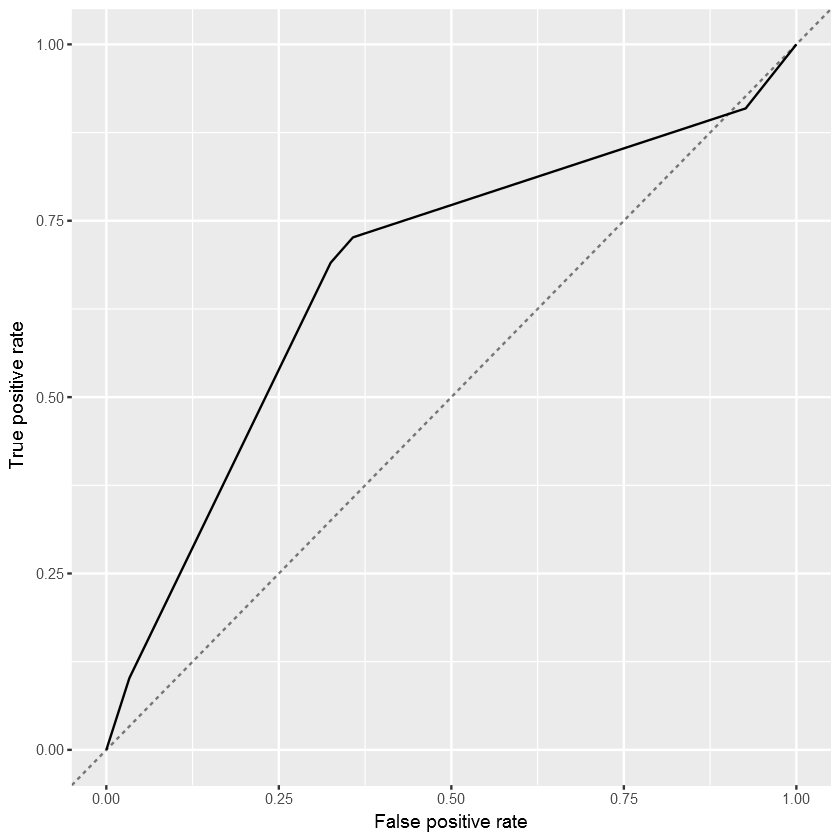

In [46]:
training.model = mlr::train(mlr.learner.xgb, mlr.task.training.ohe)
mrl.predict = predict(training.model, mlr.task.testing.ohe)
perf_ROC(mlr.predict)

#### 3.1.3 Random Forest (learner "ranger")

In [50]:
mlr.learner.ranger = makeLearner(
  "classif.ranger", 
  predict.type = "prob",
  num.trees = 1300,
  num.threads = detectCores() - 1,
  verbose = T
  )

        predicted
true       M Not_M -err.-
  M      793   651    651
  Not_M  505  1319    505
  -err.- 505   651   1156
       predicted
true    M         Not_M                        
  M     793       651       tpr: 0.55 fnr: 0.45
  Not_M 505       1319      fpr: 0.28 tnr: 0.72
        ppv: 0.61 for: 0.33 lrp: 1.98 acc: 0.65
        fdr: 0.39 npv: 0.67 lrm: 0.62 dor: 3.18


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr        f1       auc 
0.6462668 0.5491690 0.7231360 0.5784099 0.7065961 


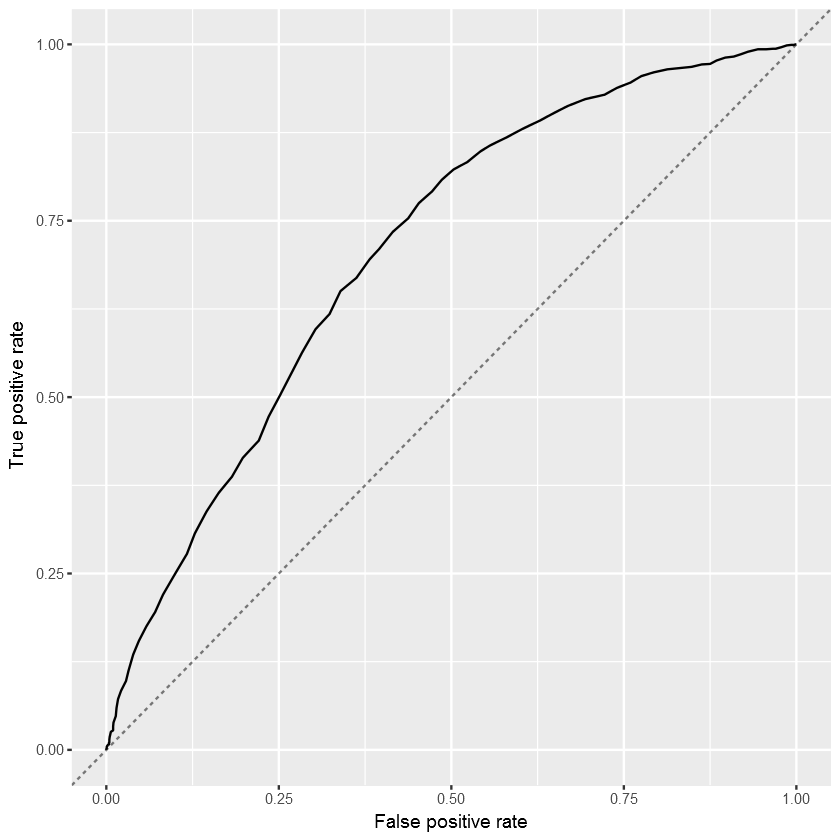

In [51]:
training.model = mlr::train(mlr.learner.ranger, mlr.task.training)
mlr.predict = predict(training.model, mlr.task.testing)
perf_ROC(mlr.predict)

#### 3.1.4 mrl ensemble

[1]	train-auc:0.675031 
Will train until train_auc hasn't improved in 10 rounds.

[101]	train-auc:0.692826 
[201]	train-auc:0.700526 
[300]	train-auc:0.707557 
        predicted
true       M Not_M -err.-
  M      919   525    525
  Not_M  545  1279    545
  -err.- 545   525   1070
       predicted
true    M         Not_M                        
  M     919       525       tpr: 0.64 fnr: 0.36
  Not_M 545       1279      fpr: 0.3  tnr: 0.7 
        ppv: 0.63 for: 0.29 lrp: 2.13 acc: 0.67
        fdr: 0.37 npv: 0.71 lrm: 0.52 dor: 4.11


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr      

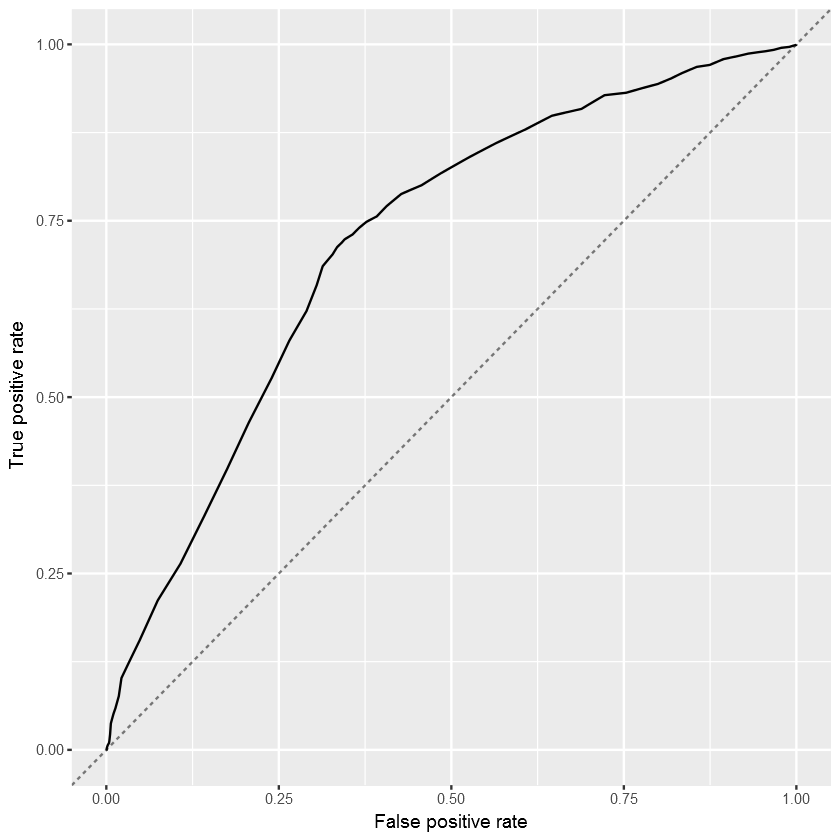

In [52]:
mlr.learners = list(mlr.learner.rpart, 
                    mlr.learner.xgb, 
                    mlr.learner.ranger)

mlr.learner.ensemble = makeStackedLearner(
  base.learners = mlr.learners, 
  predict.type = "prob", 
  method = "average"
  )

training.model.ensemble = mlr::train(mlr.learner.ensemble, mlr.task.training.ohe)
mlr.predict.ensemble = predict(training.model.ensemble, mlr.task.testing.ohe)

perf_ROC(mlr.predict.ensemble)

## References

<a id='de_livera1'></a> De Livera, A. M. (2010) [“Automatic forecasting with a modified exponential smoothing state space framework”](https://ideas.repec.org/p/msh/ebswps/2010-10.html), Monash Econometrics and Business Statistics Working Papers 10, no. 10.

<a id='de_livera2'></a> De Livera, A. M., Hyndman, R. J. and Snyder, R. D. (2011) [“Forecasting time series with complex seasonal patterns using exponential smoothing”](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771), Journal of the American Statistical Association 106, no. 496, pp. 1513-1527.

<a id='bischl'></a> Bischl, B., Lang, M., Kotthoff, L., Schiffner, J., Richter, J., Studerus, E., Casalicchio, G., Jones., Z. J. (2016) ["mlr: Machine Learning in R"](http://www.jmlr.org/papers/v17/15-066.html), Journal of Machine Learning Research 17, 1-5.